# Fine-tuned model and evaluation in dspy

In this notebook, we use DSPy Evaluate module to benchmark results from standard RAG, RAG compiled with prompt automation, and fine-tuned LLM. 

You can select 'us-west-2' region to run this notebook. 

### Environment Setup

Uncomment the following lines if the packages are not installed 

In [1]:
%%capture
!pip3 install langchain
!pip3 install -U langchain-community
!pip3 install pypdf
!pip3 install chromadb
!pip3 install dspy-ai[faiss-cpu]
!pip3 install sentence_transformers
!pip3 install continuous_eval

In [2]:
import pandas as pd
import dspy
from dspy.teleprompt import BootstrapFewShot
from dspy.evaluate import Evaluate

import pandas as pd
import logging
import json, os, shutil
import boto3, re, os, shutil
import sentence_transformers, continuous_eval

import matplotlib.pyplot as plt

### RAG generator model fine-tuned by SFT, DPO and ORPO    
   
DSPy does not yet support LLM fine-tuning through Instruction Tuning, Reinforcement Learning and Preference Alignment. Therefore, we conducted the llama 3 8B model fine-tuning separately, and generated the following results for benchmarking across multiple methods using the same dataset for the RAG inference in the notebook dapy_rag_compile.ipynb. 

If you are interested in how to fine-tune LLM using those methodologies, please refer to the code samples [here].

SFT

In [3]:
SFT_RESULTS = 'sft_trn_full_result.csv'
df_sft_data = pd.read_csv(SFT_RESULTS)
df_sft_data[:][["question", "ref_answer", "response"]].head()

,question,ref_answer,response
0,What is The name of the contract?,STRATEGIC ALLIANCE AGREEMENT,STRATEGIC ALLIANCE AGREEMENT
1,What is The two or more parties who signed the...,"Dialog Semiconductor (UK) Ltd., DIALOG, Energo...","DIALOG SEMICONDUCTOR (PENANG) SDN BHD, DIALOG ..."
2,What is The date of the contract?,"November 6, 2016","October 1, 2016"
3,What is The date when the contract is effective?,"November 6, 2016","November 6, 2016"
4,On what date will the contract's initial term ...,"Unless earlier terminated as provided herein, ...","Unless earlier terminated as provided herein, ..."


DPO

In [4]:
DPO_RESULTS = 'dpo_trn_full_result.csv'
df_dpo_data = pd.read_csv(DPO_RESULTS)
df_dpo_data.head()

,question,ref_answer,response,semantic_similarity,token_overlap_recall,rouge_l_recall
0,What is The name of the contract?,STRATEGIC ALLIANCE AGREEMENT,STRATEGIC ALLIANCE AGREEMENT,1.000000,1.000000,1.000000
1,What is The two or more parties who signed the...,"Dialog Semiconductor (UK) Ltd., DIALOG, Energo...","Dialog Semiconductor (UK) Ltd., DIALOG, Energo...",1.000000,0.750000,1.000000
2,What is The date of the contract?,"November 6, 2016","2016, October 1",0.267889,0.333333,0.000000
3,What is The date when the contract is effective?,"November 6, 2016","May 6, 2016",0.306074,0.666667,0.666667
4,On what date will the contract's initial term ...,"Unless earlier terminated as provided herein, ...","7 years after the Effective Date, and thereaft...",0.629246,0.450000,0.370370


ORPO

In [5]:
ORPO_RESULTS = 'orpo_trn_full_result.csv'
df_orpo_data = pd.read_csv(ORPO_RESULTS)
df_orpo_data.head()

,question,ref_answer,response,semantic_similarity,token_overlap_recall,rouge_l_recall
0,What is The name of the contract?,STRATEGIC ALLIANCE AGREEMENT,STRATEGIC ALLIANCE AGREEMENT,1.000000,1.000000,1.000000
1,What is The two or more parties who signed the...,"Dialog Semiconductor (UK) Ltd., DIALOG, Energo...","Dialog Semiconductor (UK) Ltd., DIALOG, Energo...",1.000000,0.750000,1.000000
2,What is The date of the contract?,"November 6, 2016","2016, October 1",0.267889,0.333333,0.000000
3,What is The date when the contract is effective?,"November 6, 2016","May 6, 2016",0.306074,0.666667,0.666667
4,On what date will the contract's initial term ...,"Unless earlier terminated as provided herein, ...","7 years after the Effective Date, and thereaft...",0.629246,0.450000,0.370370


### RAG generator model by foundation models on Bedrock

RAG with Claude Haiku for generator model (generated from the notebook dspy_rag_compile.ipynb)

In [6]:
RAG_HAIKU_RESULTS = 'rag_haiku_results_2.csv'
df_rag_haiku_data = pd.read_csv(RAG_HAIKU_RESULTS)
df_rag_haiku_data.head()

,question,ref_answer,response
0,What is The name of the contract?,STRATEGIC ALLIANCE AGREEMENT,The name of the contract is not provided in th...
1,What is The two or more parties who signed the...,"Dialog Semiconductor (UK) Ltd., DIALOG, Energo...",The two parties who signed the contract are En...
2,What is The date of the contract?,"November 6, 2016",The date of the contract is not explicitly sta...
3,What is The date when the contract is effective?,"November 6, 2016",The Effective Date
4,On what date will the contract's initial term ...,"Unless earlier terminated as provided herein, ...",Answer: 7 years\n\nReasoning: According to the...


RAG with Claude 3 Haiku for generator model, optimize by DSPy (generated from the notebook dspy_rag_compile.ipynb)

In [7]:
RAG_HAIKU_COMPILED_RESULTS = 'ragc_haiku_results_2.csv'
df_ragc_haiku_data = pd.read_csv(RAG_HAIKU_COMPILED_RESULTS)
df_ragc_haiku_data.head()

,question,ref_answer,response
0,What is The name of the contract?,STRATEGIC ALLIANCE AGREEMENT,The context provided does not explicitly state...
1,What is The two or more parties who signed the...,"Dialog Semiconductor (UK) Ltd., DIALOG, Energo...",The two parties who signed the contract are:\n...
2,What is The date of the contract?,"November 6, 2016",The effective date of the contract is November...
3,What is The date when the contract is effective?,"November 6, 2016",The effective date of the contract is November...
4,On what date will the contract's initial term ...,"Unless earlier terminated as provided herein, ...",The initial term of the contract will expire 7...


RAG with Claude 3 Sonnet for generator model (generated from the notebook dspy_rag_compile.ipynb)

In [8]:
RAG_SONNET_RESULTS = 'rag_sonnet_results_2.csv'
df_rag_sonnet_data = pd.read_csv(RAG_SONNET_RESULTS)
df_rag_sonnet_data.head()

,question,ref_answer,response
0,What is The name of the contract?,STRATEGIC ALLIANCE AGREEMENT,This appears to be an agreement between Energo...
1,What is The two or more parties who signed the...,"Dialog Semiconductor (UK) Ltd., DIALOG, Energo...","Energous Corporation, Dialog Semiconductor (UK..."
2,What is The date of the contract?,"November 6, 2016",The context does not provide the specific date...
3,What is The date when the contract is effective?,"November 6, 2016",The Effective Date
4,On what date will the contract's initial term ...,"Unless earlier terminated as provided herein, ...",7 years


RAG with Claude 3 Sonnet for generator model, optimize by DSPy (generated from the notebook dspy_rag_compile.ipynb)

In [9]:
RAG_SONNET_COMPILED_RESULTS = 'ragc_sonnet_results_2.csv'
df_ragc_sonnet_data = pd.read_csv(RAG_SONNET_COMPILED_RESULTS)
df_ragc_sonnet_data.head()

,question,ref_answer,response
0,What is The name of the contract?,STRATEGIC ALLIANCE AGREEMENT,Unfortunately the name or title of the contrac...
1,What is The two or more parties who signed the...,"Dialog Semiconductor (UK) Ltd., DIALOG, Energo...",The two parties who signed the contract are:\n...
2,What is The date of the contract?,"November 6, 2016","Unfortunately, the specific date of the contra..."
3,What is The date when the contract is effective?,"November 6, 2016","Unfortunately, the effective date of the contr..."
4,On what date will the contract's initial term ...,"Unless earlier terminated as provided herein, ...",The contract does not specify an exact date fo...


### Evaluation method 1: LLM-as-a-judge with True/False as score

Setup Claude and Meta models on Bedrock for LLM-as-a-judge

In [10]:
session = boto3.Session()
region_name = session.region_name
print(region_name)

bedrock = session.client("bedrock", region_name=region_name)
br = session.client("bedrock-runtime", region_name=region_name)

dsp_bedrock = dspy.Bedrock(region_name=region_name)

claude_sonnet_model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
clade_haiku_model_id = "anthropic.claude-3-haiku-20240307-v1:0"
llama_model_id = "us.meta.llama3-2-90b-instruct-v1:0"

bedrock_sonnet = dspy.AWSAnthropic(aws_provider=dsp_bedrock,
                                  model=claude_sonnet_model_id,
                                  max_new_tokens=4096,
                                  max_tokens=4096)

bedrock_haiku = dspy.AWSAnthropic(aws_provider=dsp_bedrock,
                                 model=clade_haiku_model_id,
                                 max_new_tokens=4096,
                                 max_tokens=4096)

bedrock_llama = dspy.AWSMeta(aws_provider=dsp_bedrock, 
                             model=llama_model_id, 
                             max_new_tokens=2048,
                             max_tokens=2048)

us-west-2


In [11]:
dspy.settings.configure(lm=bedrock_sonnet, temperature=0.1)

Define the LLM judge class: eval = True/False

In [12]:
class FactualityJudge_0(dspy.Signature):
    """Judge if the predicted answer is factually correct and similar to the groundtruth answer. Only provide 'True' or 'False' in the response."""

    groundtruth_answer = dspy.InputField(desc="groundtruth answer", format=str)
    predicted_answer = dspy.InputField(desc="predicted answer", format=str)
    factually_correct = dspy.OutputField(desc="Is the predicted answer factually correct and semantically similar to the groundtruth answer?", format=str) #, prefix="Factual[True/False]:")


In [13]:
factualityJudge_0 = dspy.ChainOfThought(FactualityJudge_0)

Define the factuality metric for DSPy evaluate to run through LLM response/answer, and use LLM judge to generate evaluation metrics

In [14]:
def factuality_metric_0(gt_answer, pred_answer):
    #print(f" type(gt_answer) :: {type(gt_answer)}")
    pred_answer = gt_answer.pred_answer
    gt_answer = gt_answer.gt_answer
        
        
    factual_metrc = factualityJudge_0(groundtruth_answer=gt_answer, predicted_answer=pred_answer), 
    '''
    #debug
    print(f"\n factual LLM judge  >>>>>>>> {factual_metrc}")
    print(f"\n factual LLM judge  >>>>>>>> {factual_metrc[0].factually_correct}")
    print(f"\n gt_answer  >>>>>>>  {gt_answer}")
    print(f"\n pred_answer  >>>>>>> {pred_answer}")
    '''
    llm_judge_ans = bool("Factual[True]" in factual_metrc[0].factually_correct or factual_metrc[0].factually_correct=='True') #or "correct" in factual.factually_correct.lower()
    print(f"llm_judge_ans = {llm_judge_ans}")
    return llm_judge_ans

In [15]:
metric_LLM_0 = factuality_metric_0

LLM Judge class to generate the answer and factual consistency

In [16]:
class LLMJudge_0(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.ChainOfThought(FactualityJudge_0)
    
    def forward(self, gt_answer, pred_answer):
        '''
        print(f"LLMJudge_0 gt_answer ----- {gt_answer}")
        print(f"LLMJudge_0 pred_answer ----- {pred_answer}")
        '''
        factual = self.generate_answer(groundtruth_answer=gt_answer, predicted_answer=pred_answer)
        #gprint(f"LLMJudge_0 factual ----- {factual}")
        #llm_judge_ans = factual.factually_correct
        
        llm_judge_ans = bool("Factual[True]" in factual.factually_correct 
                         or '100% True' in factual.factually_correct
                         or '100% factually correct' in factual.factually_correct
                         or 'True' in factual.factually_correct    
                         or factual.factually_correct=='True') #or "correct" in factual.factually_correct.lower()
        return llm_judge_ans

In [17]:
llm_judge_0 = LLMJudge_0()

Convert dataset into dspy format 

In [18]:
def generate_dspy_example_dataset(df):
    dataset_dspy_data = []

    for question, gt_answer, pred_answer in df[:][["question", "ref_answer", "response"]].values:
        '''
        print(f"question >>>>>>> {question}")
        print(f"gt_answer >>>>>>> {gt_answer}")
        print(f"pred_answer >>>>>>> {pred_answer}")
        '''
        dataset_dspy_data.append(dspy.Example(gt_answer=gt_answer, pred_answer=pred_answer).with_inputs("gt_answer", "pred_answer"))

    return dataset_dspy_data


Batch evaluation using LLM-Judge class for dataset in dataframe format 

In [19]:
def get_judge_scores_0(test_data):
    scores = []

    for index, row in test_data.iterrows():
        #print("=== ",index," ===")
        #print(f"---------------")
        #print(f"row['ref_answer'] >>>  {row['ref_answer']}")
        #print(f"row['response'] {row['response']}")
        llm_judge_ans = float(llm_judge_0(row['ref_answer'], row['response']))
        #print(f"llm_judge_ans :: {llm_judge_ans}")
        scores.append(llm_judge_ans)
        print(index,':',llm_judge_ans, end='|')

    accuracy_score = (sum(bool(score) for score in scores))/len(scores)
    
    return accuracy_score

#### LLM judge metrics by dspy 

Evaluation scores for SFT results by LLM-judge class

In [20]:
sft_score_0 = get_judge_scores_0(df_sft_data)
sft_score_0

 		You are using the client AWSAnthropic, which will be removed in DSPy 2.6.
 		Changing the client is straightforward and will let you use new features (Adapters) that improve the consistency of LM outputs, especially when using chat LMs. 

 		Learn more about the changes and how to migrate at
 		https://github.com/stanfordnlp/dspy/blob/main/examples/migration.ipynb


0 : 1.0|1 : 0.0|2 : 0.0|3 : 1.0|4 : 1.0|5 : 1.0|6 : 1.0|7 : 1.0|8 : 0.0|9 : 0.0|10 : 0.0|11 : 0.0|12 : 0.0|13 : 0.0|14 : 0.0|15 : 0.0|16 : 1.0|17 : 0.0|18 : 0.0|19 : 0.0|20 : 1.0|21 : 0.0|22 : 1.0|23 : 0.0|24 : 1.0|25 : 0.0|26 : 0.0|27 : 0.0|28 : 1.0|29 : 0.0|30 : 0.0|31 : 0.0|

0.34375

Evaluation scores for SFT results by dspy

In [21]:
evaluate_llm_judge = Evaluate(devset=generate_dspy_example_dataset(df_sft_data), 
                              metric=metric_LLM_0, 
                              num_threads=1, 
                              display_progress=True, 
                              display_table=0, 
                              provide_traceback=True)

eval_score = evaluate_llm_judge(llm_judge_0, num_threads=1)
print(f"------------- Final DSPy Evaluation score :::: {eval_score} ---------")

Average Metric: 11.00 / 32 (34.4%): 100%|██████████| 32/32 [01:01<00:00,  1.92s/it]

2024/12/18 16:59:23 INFO dspy.evaluate.evaluate: Average Metric: 11 / 32 (34.4%)



------------- Final DSPy Evaluation score :::: 34.38 ---------


In [22]:
sft_score_0 = eval_score/100
sft_score_0

0.34380000000000005

Evaluation scores for DPO results by LLM-judge class

In [23]:
dpo_score_0 = get_judge_scores_0(df_dpo_data)
dpo_score_0

0 : 1.0|1 : 1.0|2 : 0.0|3 : 0.0|4 : 1.0|5 : 1.0|6 : 0.0|7 : 1.0|8 : 0.0|9 : 0.0|10 : 1.0|11 : 1.0|12 : 1.0|13 : 0.0|14 : 1.0|15 : 1.0|16 : 1.0|17 : 0.0|18 : 0.0|19 : 0.0|20 : 1.0|21 : 0.0|22 : 1.0|23 : 1.0|24 : 1.0|25 : 0.0|26 : 0.0|27 : 0.0|28 : 1.0|29 : 1.0|30 : 1.0|31 : 1.0|

0.59375

Evaluation scores for DPO results by dspy

In [24]:
evaluate_llm_judge = Evaluate(devset=generate_dspy_example_dataset(df_dpo_data), 
                              metric=metric_LLM_0, 
                              num_threads=1, 
                              display_progress=True, display_table=0, provide_traceback=True)

eval_score = evaluate_llm_judge(llm_judge_0, num_threads=1)
print(f"------------- Final DSPy Evaluation score :::: {eval_score} ---------")

Average Metric: 19.00 / 32 (59.4%): 100%|██████████| 32/32 [01:18<00:00,  2.46s/it]

2024/12/18 17:01:25 INFO dspy.evaluate.evaluate: Average Metric: 19 / 32 (59.4%)



------------- Final DSPy Evaluation score :::: 59.38 ---------


In [25]:
dpo_score_0 = eval_score/100
dpo_score_0

0.5938

Evaluation scores for ORPO results by LLM-judge class

In [26]:
orpo_score_0 = get_judge_scores_0(df_orpo_data)
orpo_score_0

0 : 1.0|1 : 1.0|2 : 0.0|3 : 0.0|4 : 1.0|5 : 1.0|6 : 0.0|7 : 1.0|8 : 0.0|9 : 0.0|10 : 1.0|11 : 1.0|12 : 0.0|13 : 0.0|14 : 1.0|15 : 1.0|16 : 1.0|17 : 0.0|18 : 0.0|19 : 0.0|20 : 1.0|21 : 0.0|22 : 1.0|23 : 1.0|24 : 1.0|25 : 0.0|26 : 0.0|27 : 0.0|28 : 1.0|29 : 1.0|30 : 1.0|31 : 1.0|

0.5625

Evaluation scores for ORPO results by dspy

In [27]:
evaluate_llm_judge = Evaluate(devset=generate_dspy_example_dataset(df_orpo_data), 
                              metric=metric_LLM_0, 
                              num_threads=1, 
                              display_progress=True, 
                              display_table=0, 
                              provide_traceback=True)

eval_score = evaluate_llm_judge(llm_judge_0, num_threads=1)
print(f"------------- Final DSPy Evaluation score :::: {eval_score} ---------")

Average Metric: 18.00 / 32 (56.2%): 100%|██████████| 32/32 [01:27<00:00,  2.74s/it]

2024/12/18 17:03:29 INFO dspy.evaluate.evaluate: Average Metric: 18 / 32 (56.2%)



------------- Final DSPy Evaluation score :::: 56.25 ---------


In [28]:
orpo_score_0 = eval_score/100
orpo_score_0

0.5625

Evaluation scores for RAG HAIKU results by LLM-judge class

In [29]:
rag_haiku_score_0 = get_judge_scores_0(df_rag_haiku_data)
rag_haiku_score_0

0 : 0.0|1 : 0.0|2 : 0.0|3 : 0.0|4 : 1.0|5 : 1.0|6 : 1.0|7 : 1.0|8 : 0.0|9 : 0.0|10 : 0.0|11 : 0.0|12 : 1.0|13 : 0.0|14 : 0.0|15 : 1.0|16 : 0.0|17 : 0.0|18 : 0.0|19 : 0.0|20 : 0.0|21 : 0.0|22 : 0.0|23 : 0.0|24 : 1.0|25 : 0.0|26 : 0.0|27 : 0.0|28 : 0.0|29 : 0.0|30 : 0.0|31 : 0.0|

0.21875

Evaluation scores for RAG HAIKU results by dspy

In [31]:
evaluate_llm_judge = Evaluate(devset=generate_dspy_example_dataset(df_rag_haiku_data), 
                              metric=metric_LLM_0, 
                              num_threads=1, 
                              display_progress=True, 
                              display_table=0, 
                              provide_traceback=True)

eval_score = evaluate_llm_judge(llm_judge_0, num_threads=1)
print(f"------------- Final DSPy Evaluation score :::: {eval_score} ---------")

Average Metric: 6.00 / 32 (18.8%): 100%|██████████| 32/32 [02:26<00:00,  4.56s/it]

2024/12/18 17:09:21 INFO dspy.evaluate.evaluate: Average Metric: 6 / 32 (18.8%)



------------- Final DSPy Evaluation score :::: 18.75 ---------


In [32]:
rag_haiku_score_0 = eval_score/100
rag_haiku_score_0

0.1875

Evaluation scores for RAG compiled HAIKU results by LLM-judge class

In [33]:
ragc_haiku_score_0 = get_judge_scores_0(df_ragc_haiku_data)
ragc_haiku_score_0

0 : 0.0|1 : 1.0|2 : 1.0|3 : 1.0|4 : 0.0|5 : 1.0|6 : 1.0|7 : 1.0|8 : 1.0|9 : 0.0|10 : 0.0|11 : 0.0|12 : 1.0|13 : 1.0|14 : 0.0|15 : 0.0|16 : 0.0|17 : 1.0|18 : 0.0|19 : 0.0|20 : 1.0|21 : 0.0|22 : 1.0|23 : 0.0|24 : 1.0|25 : 0.0|26 : 0.0|27 : 0.0|28 : 0.0|29 : 0.0|30 : 0.0|31 : 1.0|

0.4375

Evaluation scores for RAG compiled HAIKU results by dspy

In [34]:
evaluate_llm_judge = Evaluate(devset=generate_dspy_example_dataset(df_ragc_haiku_data), 
                              metric=metric_LLM_0, 
                              num_threads=1, 
                              display_progress=True, 
                              display_table=0, 
                              provide_traceback=True)

eval_score = evaluate_llm_judge(llm_judge_0, num_threads=1)
print(f"------------- Final DSPy Evaluation score :::: {eval_score} ---------")

Average Metric: 14.00 / 32 (43.8%): 100%|██████████| 32/32 [02:17<00:00,  4.28s/it]

2024/12/18 17:12:24 INFO dspy.evaluate.evaluate: Average Metric: 14 / 32 (43.8%)



------------- Final DSPy Evaluation score :::: 43.75 ---------


In [35]:
ragc_haiku_score_0 = eval_score/100
ragc_haiku_score_0

0.4375

Evaluation scores for RAG Sonnet results by LLM-judge class

In [38]:
rag_sonnet_score_0 = get_judge_scores_0(df_rag_sonnet_data)
rag_sonnet_score_0

0 : 0.0|1 : 0.0|2 : 0.0|3 : 0.0|4 : 0.0|5 : 0.0|6 : 0.0|7 : 0.0|8 : 0.0|9 : 0.0|10 : 0.0|11 : 0.0|12 : 0.0|13 : 0.0|14 : 0.0|15 : 0.0|16 : 0.0|17 : 0.0|18 : 0.0|19 : 0.0|20 : 0.0|21 : 0.0|22 : 0.0|23 : 0.0|24 : 0.0|25 : 1.0|26 : 0.0|27 : 0.0|28 : 0.0|29 : 0.0|30 : 0.0|31 : 0.0|

0.03125

Evaluation scores for RAG Sonnet results by dspy

In [39]:
evaluate_llm_judge = Evaluate(devset=generate_dspy_example_dataset(df_rag_sonnet_data), 
                              metric=metric_LLM_0, 
                              num_threads=1, 
                              display_progress=True, 
                              display_table=0, 
                              provide_traceback=True)

eval_score = evaluate_llm_judge(llm_judge_0, num_threads=1)
print(f"------------- Final DSPy Evaluation score :::: {eval_score} ---------")

Average Metric: 1.00 / 32 (3.1%): 100%|██████████| 32/32 [02:00<00:00,  3.77s/it]

2024/12/18 17:17:56 INFO dspy.evaluate.evaluate: Average Metric: 1 / 32 (3.1%)



------------- Final DSPy Evaluation score :::: 3.12 ---------


In [40]:
rag_sonnet_score_0 = eval_score/100
rag_sonnet_score_0

0.031200000000000002

Evaluation scores for RAG compiled Sonnet results by LLM-judge class

In [41]:
ragc_sonnet_score_0 = get_judge_scores_0(df_ragc_sonnet_data)
ragc_sonnet_score_0

0 : 0.0|1 : 1.0|2 : 0.0|3 : 0.0|4 : 0.0|5 : 1.0|6 : 1.0|7 : 1.0|8 : 0.0|9 : 0.0|10 : 0.0|11 : 0.0|12 : 1.0|13 : 1.0|14 : 0.0|15 : 0.0|16 : 0.0|17 : 1.0|18 : 1.0|19 : 0.0|20 : 1.0|21 : 0.0|22 : 0.0|23 : 0.0|24 : 1.0|25 : 1.0|26 : 0.0|27 : 0.0|28 : 0.0|29 : 0.0|30 : 1.0|31 : 1.0|

0.40625

Evaluation scores for RAG compiled Sonnet results by dspy

In [42]:
evaluate_llm_judge = Evaluate(devset=generate_dspy_example_dataset(df_ragc_sonnet_data), 
                              metric=metric_LLM_0, 
                              num_threads=1, 
                              display_progress=True, 
                              display_table=0, 
                              provide_traceback=True)

eval_score = evaluate_llm_judge(llm_judge_0, num_threads=1)
print(f"------------- Final DSPy Evaluation score :::: {eval_score} ---------")

Average Metric: 13.00 / 32 (40.6%): 100%|██████████| 32/32 [01:37<00:00,  3.04s/it]

2024/12/18 17:20:27 INFO dspy.evaluate.evaluate: Average Metric: 13 / 32 (40.6%)



------------- Final DSPy Evaluation score :::: 40.62 ---------


In [43]:
ragc_sonnet_score_0 = eval_score/100
ragc_sonnet_score_0

0.40619999999999995

#### Benchmarking the performance across RAG with foundation models and fine-tuned models 

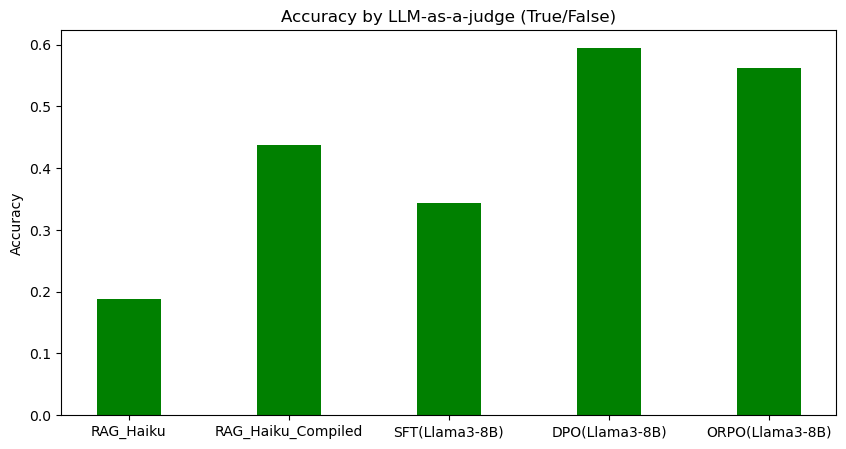

In [44]:
train_class_type = ['RAG_Haiku','RAG_Haiku_Compiled','SFT(Llama3-8B)','DPO(Llama3-8B)','ORPO(Llama3-8B)']
train_class_count = [rag_haiku_score_0,ragc_haiku_score_0,sft_score_0,dpo_score_0,orpo_score_0,]

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(train_class_type, train_class_count, color ='green', width = 0.4)

plt.xlabel("")
plt.ylabel("Accuracy")
plt.title("Accuracy by LLM-as-a-judge (True/False)")
plt.show()

### Evaluation Method 2: LLM-as-a-judge with a 0-1 score 

Setup Claude and Meta models on Bedrock for LLM-as-a-judge

In [45]:
dsp_bedrock = dspy.Bedrock(region_name='us-west-2')

claude_sonnet_model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
clade_haiku_model_id = "anthropic.claude-3-haiku-20240307-v1:0"
llama_model_id = "us.meta.llama3-2-90b-instruct-v1:0"


bedrock_sonnet = dspy.AWSAnthropic(aws_provider=dsp_bedrock,
                                  model=claude_sonnet_model_id,
                                  max_new_tokens=4096,
                                  max_tokens=4096)

bedrock_haiku = dspy.AWSAnthropic(aws_provider=dsp_bedrock,
                                 model=clade_haiku_model_id,
                                 max_new_tokens=4096,
                                 max_tokens=4096)

bedrock_llama = dspy.AWSMeta(aws_provider=dsp_bedrock, 
                             model=llama_model_id, 
                             max_new_tokens=2048,
                             max_tokens=2048)

In [46]:
dspy.settings.configure(lm=bedrock_sonnet, temperature=0)

Define the LLM judge class: eval = 0-1 score

In [47]:
class FactualityJudge_1(dspy.Signature):
    """Judge if the predicted answer is semantically match the groundtruth answer. Provide a score between 0 and 1, 0 means completely mismatch and 1 means perfectly match. In the response, only present the score, DO NOT add any premables."""

    groundtruth_answer = dspy.InputField(desc="groundtruth answer")
    predicted_answer = dspy.InputField(desc="predicted answer")
    factually_correct = dspy.OutputField(desc="Is the predicted answer factually correct and semantically similar to the groundtruth answer?") #, prefix="Factual[True/False]:")


In [48]:
factualityJudge_1 = dspy.ChainOfThought(FactualityJudge_1)

Define the factuality metric for DSPy evaluate to run through LLM response/answer, and use LLM judge to generate evaluation metrics

In [49]:
def factuality_metric_1(gt_answer, pred_answer):
    #print(f" type(gt_answer) :: {type(gt_answer)}")
    #if type(gt_answer) == "<class 'dspy.primitives.example.Example'>":
    pred_answer = gt_answer.pred_answer
    gt_answer = gt_answer.gt_answer
        
        
    factual_metrc = factualityJudge_1(groundtruth_answer=gt_answer, predicted_answer=pred_answer), 
    '''
    #debug
    print(f"\n factual LLM judge  >>>>>>>> {factual_metrc}")
    print(f"\n factual LLM judge  >>>>>>>> {factual_metrc[0].factually_correct}")
    print(f"\n gt_answer  >>>>>>>  {gt_answer}")
    print(f"\n pred_answer  >>>>>>> {pred_answer}")
    '''
    llm_judge_ans = float(factual_metrc[0].factually_correct)
    print(f"llm_judge_ans = {llm_judge_ans}")
    return llm_judge_ans

In [50]:
metric_LLM_1 = factuality_metric_1

LLM Judge class to generate the answer and factual consistency

In [51]:
class LLMJudge_1(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.ChainOfThought(FactualityJudge_1)
    
    def forward(self, gt_answer, pred_answer):
        factual = self.generate_answer(groundtruth_answer=gt_answer, predicted_answer=pred_answer)
        #print(f"factual LLM judge reasoning {factual}")
        llm_judge_ans = factual.factually_correct
        
        return llm_judge_ans

In [52]:
llm_judge_1 = LLMJudge_1()

Batch evaluation using LLM-Judge class for dataset in dataframe format 

In [53]:
def get_judge_score_1(test_data):
    scores = []

    for index, row in test_data.iterrows():
        #print("=== ",index," ===")
        #print(f"---------------")
        #print(f"row['ref_answer'] >>>  {row['ref_answer']}")
        #print(f"row['response'] {row['response']}")
        llm_judge_ans = float(llm_judge_1(row['ref_answer'], row['response']))
        #print(f"llm_judge_ans :: {llm_judge_ans}")
        scores.append(llm_judge_ans)
        print(index,':',llm_judge_ans, end='|')

    accuracy_score = sum(scores)/len(scores)
    
    return accuracy_score

### LLM judge metrics by dspy 

Evaluation scores for SFT results by LLM-judge class

In [54]:
sft_score_1 = get_judge_score_1(df_sft_data)
sft_score_1

0 : 1.0|1 : 0.3|2 : 0.2|3 : 1.0|4 : 1.0|5 : 1.0|6 : 1.0|7 : 0.9|8 : 0.0|9 : 0.0|10 : 0.2|11 : 0.2|12 : 0.6|13 : 0.2|14 : 0.0|15 : 0.0|16 : 1.0|17 : 0.0|18 : 0.1|19 : 0.2|20 : 0.9|21 : 0.3|22 : 0.9|23 : 0.2|24 : 1.0|25 : 0.1|26 : 0.0|27 : 0.3|28 : 1.0|29 : 0.8|30 : 0.1|31 : 0.9|

0.48125000000000007

Evaluation scores for SFT results by dspy

In [56]:
evaluate_llm_judge = Evaluate(devset=generate_dspy_example_dataset(df_sft_data), 
                              metric=metric_LLM_1, 
                              num_threads=1, 
                              display_progress=True, 
                              display_table=0, 
                              provide_traceback=True)

eval_score = evaluate_llm_judge(llm_judge_1, num_threads=1)
print(f"------------- Final DSPy Evaluation score :::: {eval_score} ---------")

Average Metric: 12.30 / 32 (38.4%):  78%|███████▊  | 25/32 [01:20<00:42,  6.13s/it]

2024/12/18 17:27:23 ERROR dspy.utils.parallelizer: Error processing item Example({'gt_answer': 'ENERGOUS hereby grants DIALOG a non-exclusive, non-transferable (except as set forth in Section 2) license under the Product IP to use any of the Deposit Materials released from escrow for the purpose of fixing an Epidemic Defect or other Product design or production issue impacting yield or quality during the Term and, if applicable, any Wind Down Period or Continuing Obligation period, including, but not limited to, authorizing any third party subcontractor to manufacture and supply Products, provided, however, that DIALOG continues to make all Royalty payment owed to ENERGOUS (or the then-current owner of the Product IP) as provided in this Agreement., ENERGOUS will keep the Deposit Materials in escrow and ensure on a quarterly basis that all the information relating to the Deposit Materials in escrow is current, including deposit of any Product Updates., DIALOG agrees not to exercise suc

Average Metric: 12.30 / 32 (38.4%):  84%|████████▍ | 27/32 [01:33<00:31,  6.39s/it]

2024/12/18 17:27:38 ERROR dspy.utils.parallelizer: Error processing item Example({'gt_answer': "During the Record Retention Period, ENERGOUS may appoint a mutually agreed independent, internationally recognized third-party certified auditor who will have the right to inspect and copy the Records upon reasonable prior notice, and DIALOG will (and will cause its Affiliates to) allow necessary access including, as applicable, to its premises where such Records are located. ENERGOUS may exercise such right to this independent-third party audit no more than one time per calendar year and each such audit will be conducted during normal business hours., Such audit may also not interfere with DIALOG's or its Affliates' quarterly closing of its books.", 'pred_answer': 'Each party, during [***], subject to the restrictions and notice requirements set forth below, may (a) inspect and copy the other party\'s records and (b) have an independent auditor inspect and copy the other party\'s records, a

Average Metric: 12.30 / 32 (38.4%):  88%|████████▊ | 28/32 [01:40<00:27,  6.81s/it]

2024/12/18 17:27:51 ERROR dspy.utils.parallelizer: Error processing item Example({'gt_answer': "EXCEPT IN THE CASE OF (a) ANY BREACH OF SECTION 10 (CONFIDENTIALITY), (b) THE PARTIES' OBLIGATIONS UNDER SECTION 12 (INDEMNIFICATION), (c) A PARTY'S GROSS NEGLIGENCE OR WILLFUL MISCONDUCT, OR (d) LIABILITY ARISING FROM EPIDEMIC DEFECTS (WHICH WILL BE SUBJECT TO THE LIMITATION SET FORTH IN SECTION 11.2(d)), IN NO EVENT WILL EITHER PARTY BE LIABLE UNDER THIS AGREEMENT, REGARDLESS OF THE FORM OF ANY CLAIM OR ACTION (WHETHER IN CONTRACT, NEGLIGENCE, STRICT LIABILITY OR OTHERWISE), FOR ANY (i) INDIRECT, PUNITIVE, INCIDENTAL, RELIANCE, SPECIAL, EXEMPLARY OR CONSEQUENTIAL DAMAGES, INCLUDING, BUT NOT LIMITED TO, LOSS OF BUSINESS, REVENUES, PROFITS OR GOODWILL, OR (ii) AGGREGATE DAMAGES IN EXCESS OF [***].", 'pred_answer': "EXCEPT IN THE CASE OF (a) ANY BREACH OF SECTION 10 (CONFIDENTIALITY), (b) THE PARTIES' OBLIGATIONS UNDER SECTION 12 (INDEMNIFICATION), (c) A PARTY'S GROSS NEGLIGENCE OR WILLFUL MI

Average Metric: 14.10 / 32 (44.1%): 100%|██████████| 32/32 [02:28<00:00,  4.64s/it]

2024/12/18 17:28:25 INFO dspy.evaluate.evaluate: Average Metric: 14.100000000000001 / 32 (44.1%)



------------- Final DSPy Evaluation score :::: 44.06 ---------


In [57]:
sft_score_1 = eval_score/100
sft_score_1

0.44060000000000005

Evaluation scores for DPO results by LLM-judge class

In [59]:
dpo_score_1 = get_judge_score_1(df_dpo_data)
dpo_score_1

0 : 1.0|1 : 1.0|2 : 0.2|3 : 0.2|4 : 0.9|5 : 1.0|6 : 0.2|7 : 1.0|8 : 0.2|9 : 0.2|10 : 1.0|11 : 1.0|12 : 1.0|13 : 0.2|14 : 1.0|15 : 1.0|16 : 1.0|17 : 0.0|18 : 0.1|19 : 0.1|20 : 1.0|21 : 0.9|22 : 0.9|23 : 1.0|24 : 1.0|25 : 0.3|26 : 0.1|27 : 0.2|28 : 1.0|29 : 0.9|30 : 1.0|31 : 1.0|

0.675

Evaluation scores for DPO results by LLM-judge class

In [60]:
evaluate_llm_judge = Evaluate(devset=generate_dspy_example_dataset(df_dpo_data), 
                              metric=metric_LLM_1, 
                              num_threads=1, 
                              display_progress=True, 
                              display_table=0, 
                              provide_traceback=True)

eval_score = evaluate_llm_judge(llm_judge_1, num_threads=1)
print(f"------------- Final DSPy Evaluation score :::: {eval_score} ---------")

Average Metric: 21.50 / 32 (67.2%): 100%|██████████| 32/32 [01:07<00:00,  2.11s/it]

2024/12/18 17:30:56 INFO dspy.evaluate.evaluate: Average Metric: 21.5 / 32 (67.2%)



------------- Final DSPy Evaluation score :::: 67.19 ---------


In [61]:
dpo_score_1 = eval_score/100
dpo_score_1

0.6718999999999999

Evaluation scores for ORPO results by LLM-judge class

In [62]:
orpo_score_1 = get_judge_score_1(df_orpo_data)
orpo_score_1

0 : 1.0|1 : 1.0|2 : 0.2|3 : 0.2|4 : 0.9|5 : 1.0|6 : 0.2|7 : 1.0|8 : 0.2|9 : 0.2|10 : 1.0|11 : 1.0|12 : 0.9|13 : 0.2|14 : 1.0|15 : 1.0|16 : 1.0|17 : 0.0|18 : 0.1|19 : 0.1|20 : 1.0|21 : 0.9|22 : 0.9|23 : 1.0|24 : 1.0|25 : 0.8|26 : 0.0|27 : 0.2|28 : 1.0|29 : 0.9|30 : 1.0|31 : 1.0|

0.684375

Evaluation scores for ORPO results by dspy

In [63]:
evaluate_llm_judge = Evaluate(devset=generate_dspy_example_dataset(df_orpo_data), 
                              metric=metric_LLM_1, 
                              num_threads=1, 
                              display_progress=True, 
                              display_table=0, 
                              provide_traceback=True)

eval_score = evaluate_llm_judge(llm_judge_1, num_threads=1)
print(f"------------- Final DSPy Evaluation score :::: {eval_score} ---------")

Average Metric: 21.80 / 32 (68.1%): 100%|██████████| 32/32 [01:12<00:00,  2.26s/it]

2024/12/18 17:32:45 INFO dspy.evaluate.evaluate: Average Metric: 21.799999999999997 / 32 (68.1%)



------------- Final DSPy Evaluation score :::: 68.12 ---------


In [64]:
orpo_score_1 = eval_score/100
orpo_score_1

0.6812

Evaluation scores for RAG HAIKU results by LLM-judge class

In [65]:
rag_haiku_score_1 = get_judge_score_1(df_rag_haiku_data)
rag_haiku_score_1

0 : 0.1|1 : 1.0|2 : 0.1|3 : 0.1|4 : 0.5|5 : 0.9|6 : 1.0|7 : 1.0|8 : 0.2|9 : 0.2|10 : 0.3|11 : 0.1|12 : 0.9|13 : 0.0|14 : 0.2|15 : 1.0|16 : 0.9|17 : 0.5|18 : 0.1|19 : 0.1|20 : 0.2|21 : 0.3|22 : 0.1|23 : 0.6|24 : 0.7|25 : 0.8|26 : 0.3|27 : 0.0|28 : 0.9|29 : 0.8|30 : 0.2|31 : 0.0|

0.440625

Evaluation scores for RAG HAIKU results by dspy

In [66]:
evaluate_llm_judge = Evaluate(devset=generate_dspy_example_dataset(df_rag_haiku_data), 
                              metric=metric_LLM_1, 
                              num_threads=1, 
                              display_progress=True, 
                              display_table=0, 
                              provide_traceback=True)

eval_score = evaluate_llm_judge(llm_judge_1, num_threads=1)
print(f"------------- Final DSPy Evaluation score :::: {eval_score} ---------")

Average Metric: 14.20 / 32 (44.4%): 100%|██████████| 32/32 [01:05<00:00,  2.06s/it]

2024/12/18 17:34:24 INFO dspy.evaluate.evaluate: Average Metric: 14.2 / 32 (44.4%)



------------- Final DSPy Evaluation score :::: 44.38 ---------


In [67]:
rag_haiku_score_1 = eval_score/100
rag_haiku_score_1

0.44380000000000003

Evaluation scores for RAG compiled HAIKU results by LLM-judge class

In [68]:
ragc_haiku_score_1 = get_judge_score_1(df_ragc_haiku_data)
ragc_haiku_score_1

0 : 0.2|1 : 1.0|2 : 1.0|3 : 1.0|4 : 0.5|5 : 0.9|6 : 1.0|7 : 0.9|8 : 0.9|9 : 0.6|10 : 0.2|11 : 0.2|12 : 0.9|13 : 1.0|14 : 0.2|15 : 0.8|16 : 0.6|17 : 1.0|18 : 0.0|19 : 0.1|20 : 0.9|21 : 0.5|22 : 0.8|23 : 0.5|24 : 0.9|25 : 0.9|26 : 0.8|27 : 0.1|28 : 0.4|29 : 0.9|30 : 0.8|31 : 0.9|

0.66875

Evaluation scores for RAG compiled HAIKU results by dspy

In [69]:
evaluate_llm_judge = Evaluate(devset=generate_dspy_example_dataset(df_ragc_haiku_data), 
                              metric=metric_LLM_1, 
                              num_threads=1, 
                              display_progress=True, 
                              display_table=0, 
                              provide_traceback=True)

eval_score = evaluate_llm_judge(llm_judge_1, num_threads=1)
print(f"------------- Final DSPy Evaluation score :::: {eval_score} ---------")

Average Metric: 21.20 / 32 (66.2%): 100%|██████████| 32/32 [01:03<00:00,  1.99s/it]

2024/12/18 17:36:00 INFO dspy.evaluate.evaluate: Average Metric: 21.199999999999996 / 32 (66.2%)



------------- Final DSPy Evaluation score :::: 66.25 ---------


In [70]:
ragc_haiku_score_1 = eval_score/100
ragc_haiku_score_1

0.6625

Evaluation scores for RAG Sonnet results by LLM-judge class

In [71]:
rag_sonnet_score_1 = get_judge_score_1(df_rag_sonnet_data)
rag_sonnet_score_1

0 : 0.2|1 : 0.9|2 : 0.1|3 : 0.1|4 : 0.5|5 : 0.2|6 : 0.2|7 : 0.8|8 : 0.3|9 : 0.2|10 : 0.0|11 : 0.2|12 : 0.0|13 : 0.5|14 : 0.2|15 : 0.2|16 : 0.8|17 : 0.0|18 : 0.0|19 : 0.2|20 : 0.2|21 : 0.3|22 : 0.1|23 : 0.2|24 : 0.2|25 : 0.9|26 : 0.8|27 : 0.0|28 : 0.2|29 : 0.2|30 : 1.0|31 : 0.2|

0.309375

Evaluation scores for RAG Sonnet results by dspy

In [72]:
evaluate_llm_judge = Evaluate(devset=generate_dspy_example_dataset(df_rag_sonnet_data), 
                              metric=metric_LLM_1, 
                              num_threads=1, 
                              display_progress=True, 
                              display_table=0, 
                              provide_traceback=True)

eval_score = evaluate_llm_judge(llm_judge_1, num_threads=1)
print(f"------------- Final DSPy Evaluation score :::: {eval_score} ---------")

Average Metric: 9.60 / 32 (30.0%): 100%|██████████| 32/32 [01:23<00:00,  2.61s/it]

2024/12/18 17:37:58 INFO dspy.evaluate.evaluate: Average Metric: 9.6 / 32 (30.0%)



------------- Final DSPy Evaluation score :::: 30.0 ---------


In [73]:
rag_sonnet_score_1 = eval_score/100
rag_sonnet_score_1

0.3

Evaluation scores for RAG compiled Sonnet results by LLM-judge class

In [75]:
ragc_sonnet_score_1 = get_judge_score_1(df_ragc_sonnet_data)
ragc_sonnet_score_1

0 : 0.1|1 : 1.0|2 : 0.1|3 : 0.1|4 : 0.3|5 : 0.9|6 : 0.9|7 : 0.9|8 : 0.3|9 : 0.6|10 : 0.1|11 : 0.2|12 : 0.9|13 : 1.0|14 : 0.2|15 : 0.8|16 : 0.9|17 : 0.9|18 : 0.9|19 : 0.9|20 : 0.9|21 : 0.4|22 : 0.8|23 : 0.9|24 : 0.9|25 : 0.9|26 : 0.4|27 : 0.1|28 : 0.4|29 : 0.5|30 : 0.9|31 : 0.9|

0.625

Evaluation scores for RAG compiled Sonnet results by dspy

In [76]:
evaluate_llm_judge = Evaluate(devset=generate_dspy_example_dataset(df_ragc_sonnet_data), 
                              metric=metric_LLM_1, 
                              num_threads=1, 
                              display_progress=True, 
                              display_table=0, 
                              provide_traceback=True)

eval_score = evaluate_llm_judge(llm_judge_1, num_threads=1)
print(f"------------- Final DSPy Evaluation score :::: {eval_score} ---------")

Average Metric: 20.00 / 32 (62.5%): 100%|██████████| 32/32 [01:04<00:00,  2.03s/it]

2024/12/18 17:45:42 INFO dspy.evaluate.evaluate: Average Metric: 20.0 / 32 (62.5%)



------------- Final DSPy Evaluation score :::: 62.5 ---------


In [77]:
ragc_sonnet_score_1 = eval_score/100
ragc_sonnet_score_1

0.625

### Benchmarking the performance across RAG with foundation models and fine-tuned models 

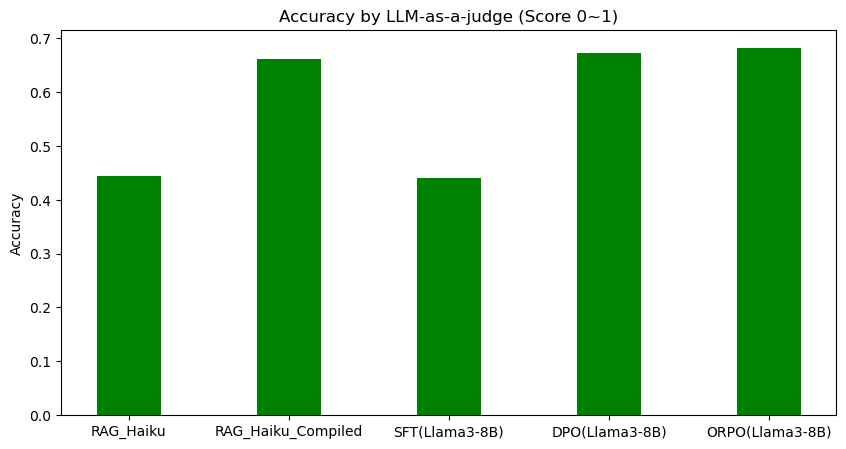

In [78]:
train_class_type = ['RAG_Haiku','RAG_Haiku_Compiled','SFT(Llama3-8B)','DPO(Llama3-8B)','ORPO(Llama3-8B)']
train_class_count = [rag_haiku_score_1,ragc_haiku_score_1,sft_score_1,dpo_score_1,orpo_score_1,]

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(train_class_type, train_class_count, color ='green', width = 0.4)

plt.xlabel("")
plt.ylabel("Accuracy")
plt.title("Accuracy by LLM-as-a-judge (Score 0~1)")
plt.show()